# Part3: MobileBERT for Text Prediction

Now you have learned 1) the basics about Gluon, 2) how to use the backbone models in GluonNLP, 3) how to use the tokenizer and vocabulary in GluonNLP. In this part, we are going to build a model that finetunes [MobileBERT](https://arxiv.org/pdf/2004.02984.pdf) for text prediction problems.

In [1]:
import gluonnlp
import numpy as np
import mxnet as mx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mxnet.gluon import nn
from gluonnlp.models import get_backbone
from gluonnlp.utils.parameter import clip_grad_global_norm
from gluonnlp.utils.preprocessing import get_trimmed_lengths
from gluonnlp.utils.misc import get_mxnet_visible_ctx, grouper, repeat
from mxnet.gluon.data import batchify as bf
from mxnet.gluon.data import DataLoader
from mxnet.lr_scheduler import PolyScheduler
from gluonnlp.utils import set_seed
mx.npx.set_np()
set_seed(123)

### Load Dataset

In [2]:
!nlp_data prepare_glue --benchmark glue -t sst
!nlp_data prepare_glue --benchmark glue -t sts

Processing sst...
Found!
Processing sts...
Found!


In [3]:
sst_train_df = pd.read_parquet('glue/sst/train.parquet')
# For simplicity, we just use 2000 samples for training for SST
rng_state = np.random.RandomState(123)
train_perm = rng_state.permutation(len(sst_train_df))
# Just use 2000 samples for training
sst_train_df = sst_train_df.iloc[train_perm[:2000]]
sst_dev_df = pd.read_parquet('glue/sst/dev.parquet')

In [4]:
# Load STS
sts_train_df = pd.read_parquet('glue/sts/train.parquet')[['sentence1', 'sentence2', 'score']]
sts_dev_df = pd.read_parquet('glue/sts/dev.parquet')[['sentence1', 'sentence2', 'score']]

In [5]:
sst_train_df.head(10)

,sentence,label
2434,goes by quickly,1
27796,reading lines from a teleprompter,0
249,"degraded , handheld blair witch video-cam foot...",0
12115,reminds us how realistically nuanced a robert ...,1
50834,indulges in the worst elements of all of them .,0
43622,are nowhere near as vivid as the 19th-century ...,0
3955,throughout a film that is both gripping and co...,1
51011,to see over and over again,1
31232,that fails to match the freshness of the actre...,0
32153,this is an undeniably intriguing film from an ...,1


In [6]:
sts_train_df.head(10)

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25
5,Some men are fighting.,Two men are fighting.,4.25
6,A man is smoking.,A man is skating.,0.50
7,The man is playing the piano.,The man is playing the guitar.,1.60
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.20
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.00


### Load MobileBERT

In [7]:
model_cls, cfg, tokenizer, local_params_path, _ = get_backbone('google_uncased_mobilebert')
backbone = model_cls.from_cfg(cfg)
print(cfg)

INITIALIZER:
  bias: ['zeros']
  embed: ['truncnorm', 0, 0.02]
  weight: ['truncnorm', 0, 0.02]
MODEL:
  activation: relu
  attention_dropout_prob: 0.1
  bottleneck_strategy: qk_sharing
  classifier_activation: False
  compute_layout: auto
  dtype: float32
  embed_size: 128
  hidden_dropout_prob: 0.0
  hidden_size: 512
  inner_size: 128
  layer_norm_eps: 1e-12
  layout: NT
  max_length: 512
  normalization: no_norm
  num_heads: 4
  num_layers: 24
  num_stacked_ffn: 4
  num_token_types: 2
  pos_embed_type: learned
  trigram_embed: True
  units: 512
  use_bottleneck: True
  vocab_size: 30522
VERSION: 1


### Preprocess the Data

First of all, let's preprocess the data. Similar to BERT, in MobileBERT, we warp the data as

- <font color='red'>[CLS]</font> TOKENS <font color='red'>[SEP]</font>
- <font color='red'>[CLS]</font> TOKENS1 <font color='red'>[SEP]</font> TOKENS2 <font color='red'>[SEP]</font>

In addition, to handle a pair of sentences, we generate the segment IDs, which will be 0 for the first sentence and 1 for the second sentence.

In [8]:
def preprocess_data(df, feature_columns, label_column, tokenizer, max_length=128, use_label=True):
    out = []
    if isinstance(feature_columns, str):
        feature_columns = [feature_columns]
    cls_id = tokenizer.vocab.cls_id
    sep_id = tokenizer.vocab.sep_id
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        # Token IDs =      [CLS]    token_ids1       [SEP]      token_ids2         [SEP]
        # Segment IDs =      0         0               0           1                 1
        encoded_text_l = [tokenizer.encode(row[col_name], int) for col_name in feature_columns]
        trimmed_lengths = get_trimmed_lengths([len(ele) for ele in encoded_text_l],
                                              max_length=max_length - len(feature_columns) - 1,
                                              do_merge=True)
        token_ids = [cls_id] + sum([ele[:length] + [sep_id]
                          for length, ele in zip(trimmed_lengths, encoded_text_l)], [])
        token_types = [0] + sum([[i % 2] * (length + 1) for i, length in enumerate(trimmed_lengths)], [])
        valid_length = len(token_ids)
        feature = (token_ids, token_types, valid_length)
        if use_label:
            label = row[label_column]
            out.append((feature, label))
        else:
            out.append(feature)
    return out

In [9]:
processed_sst_train = preprocess_data(sst_train_df, 'sentence', 'label', tokenizer, use_label=True)
processed_sst_dev = preprocess_data(sst_dev_df, 'sentence', 'label', tokenizer, use_label=False)
print(sst_train_df.iloc[:2])
print(processed_sst_train[:2])


                                 sentence  label
2434                     goes by quickly       1
27796  reading lines from a teleprompter       0
[(([101, 3632, 2011, 2855, 102], [0, 0, 0, 0, 0], 5), 1), (([101, 3752, 3210, 2013, 1037, 10093, 13699, 21716, 13876, 2121, 102], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 11), 0)]


In [10]:
processed_sts_train = preprocess_data(sts_train_df, ['sentence1', 'sentence2'], 'score', tokenizer, use_label=True)
processed_sts_dev = preprocess_data(sts_dev_df, ['sentence1', 'sentence2'], 'score', tokenizer, use_label=False)
print(sts_train_df.iloc[:2])
print(processed_sts_train[:2])


                         sentence1                    sentence2  score
0           A plane is taking off.  An air plane is taking off.    5.0
1  A man is playing a large flute.    A man is playing a flute.    3.8
[(([101, 1037, 4946, 2003, 2635, 2125, 1012, 102, 2019, 2250, 4946, 2003, 2635, 2125, 1012, 102], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 16), 5.0), (([101, 1037, 2158, 2003, 2652, 1037, 2312, 8928, 1012, 102, 1037, 2158, 2003, 2652, 1037, 8928, 1012, 102], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 18), 3.8)]


After processing,
- Train Sample: `((token_ids, token_types, valid_length), label)`
- Valid Sample: `(token_ids, token_types, valid_length)`

### Handle Variable Length Sequence

When sample minibatches for text classification/regression, each text may not have the same length. You can use the built-in batchify functions in Gluon to help convert the data into batches.

Recall that we have,
- Train Sample: `((token_ids, token_types, valid_length), label)`
- Valid Sample: `(token_ids, token_types, valid_length)`

The corresponding batchify can be constructed similar to the python typing notation
- Train: `Group[Group[Pad, Pad, Stack], Stack]`
- Train: `Group[Pad, Pad, Stack]`

In [11]:
train_batchify = bf.Group(bf.Group(bf.Pad(), bf.Pad(), bf.Stack()),
                          bf.Stack())
dev_batchify = bf.Group(bf.Pad(), bf.Pad(), bf.Stack())

Let's see how the batchify works. We try to merge two samples into a batch:

In [12]:
train_batchify([processed_sst_train[0], processed_sst_train[1]])

((array([[  101,  3632,  2011,  2855,   102,     0,     0,     0,     0,
              0,     0],
         [  101,  3752,  3210,  2013,  1037, 10093, 13699, 21716, 13876,
           2121,   102]], dtype=int64),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64),
  array([ 5, 11], dtype=int64)),
 array([1, 0], dtype=int64))

In [13]:
dev_batchify([processed_sst_dev[0], processed_sst_dev[1]])

(array([[  101,  2009,  1005,  1055,  1037, 11951,  1998,  2411, 12473,
          4990,  1012,   102],
        [  101,  4895, 10258,  2378,  8450,  2135, 21657,  1998,  7143,
           102,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64),
 array([12, 10], dtype=int64))

### Construct the Network

Next, let's construct a very simple network that uses the backbone to encode the sentence and adds another fully-connected layer to map the features into scores.

In [14]:
class TextPredictionNet(nn.HybridBlock):
    def __init__(self, backbone, in_units, out_units):
        """Construct the TextPrediction Network

        Parameters
        ----------
        backbone
            The backbone model
        in_units
            The units of the features extracted by the backbone model
        out_units
            The number of output units
        """
        super().__init__()
        self.backbone = backbone
        self.out_proj = nn.Dense(in_units=in_units,
                                 units=out_units,
                                 flatten=False)

    def hybrid_forward(self, F, data, token_types, valid_length):
        """

        Parameters
        ----------
        F
        data
            The input data.
            The shape is (batch_size, seq_length)
        token_types
            The type of each token.
        valid_length
            The valid length of each sample.
            Shape is (batch_size,)

        Returns
        -------
        out
            Shape is (batch_size, units)
        """
        _, pooled_out = self.backbone(data, token_types, valid_length)
        out = self.out_proj(pooled_out)
        return out

    def initialize_with_pretrained_backbone(self, backbone_params_path, ctx=None):
        """Initialize the network with pretrained backbone

        Parameters
        ----------
        backbone_params_path
        ctx

        Returns
        -------

        """
        self.backbone.load_parameters(backbone_params_path, ctx=ctx)
        self.out_proj.initialize(ctx=ctx)

In [15]:
ctx_l = get_mxnet_visible_ctx()
net_sst = TextPredictionNet(backbone, backbone.units, 2)
net_sst.hybridize()
net_sst.initialize_with_pretrained_backbone(local_params_path, ctx_l)

### Train and Evaluate

Next, we can write the training loop. Here, we will use the [ADAMW optimizer](https://arxiv.org/pdf/1711.05101.pdf), gradient clipping and [Slanted Triangular Learning Rate](https://arxiv.org/pdf/1801.06146.pdf).

Text(0.5, 1.0, 'Slanted Triangular Learning Rate')

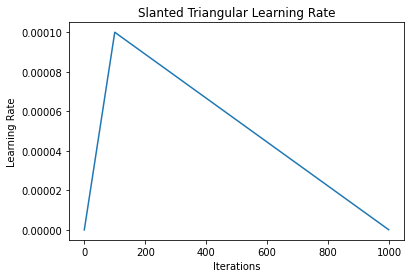

In [16]:
total_iterations = 1000
warmup = 100
x = np.arange(total_iterations)
max_lr = 1E-4
y = (x < warmup) * max_lr * x / warmup + (x >= warmup) * (total_iterations - x) * max_lr / (total_iterations - warmup)
plt.plot(x, y)
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.title('Slanted Triangular Learning Rate')


In [17]:
def train(batch_size, dataset, batchify_function, net, ctx_l,
          num_epochs, lr=1E-4, wd=0.01, max_grad_norm=1.0, warmup_ratio=0.1,
          loss_function='nll'):
    assert batch_size % len(ctx_l) == 0
    per_device_batch_size = batch_size // len(ctx_l)
    epoch_num_updates = len(dataset) // batch_size
    max_update = epoch_num_updates * num_epochs
    warmup_steps = int(np.ceil(max_update * warmup_ratio))
    dataloader = DataLoader(dataset,
                            batch_size=per_device_batch_size,
                            batchify_fn=batchify_function,
                            num_workers=4,
                            shuffle=True)
    dataloader = grouper(repeat(dataloader), len(ctx_l))
    
    # Construct the learning rate scheduler
    lr_scheduler = PolyScheduler(max_update=max_update,
                                 base_lr=lr,
                                 warmup_begin_lr=0.0,
                                 pwr=1,
                                 final_lr=0.0,
                                 warmup_steps=warmup_steps,
                                 warmup_mode='linear')
    optimizer_params = {'learning_rate': lr,
                        'wd': wd,
                        'lr_scheduler': lr_scheduler}
    trainer = mx.gluon.Trainer(net.collect_params(),
                               'adamw',
                               optimizer_params)
    params = [p for p in net.collect_params().values() if p.grad_req != 'null']
    log_loss = 0
    log_gnorm = 0
    log_step = 0
    log_interval = int(epoch_num_updates * 0.1)
    for i in range(max_update):
        sample_l = next(dataloader)
        loss_l = []
        for sample, ctx in zip(sample_l, ctx_l):
            (token_ids, token_types, valid_length), label = sample
            # Move to the corresponding context
            token_ids = mx.np.array(token_ids, ctx=ctx)
            token_types = mx.np.array(token_types, ctx=ctx)
            valid_length = mx.np.array(valid_length, ctx=ctx)
            label = mx.np.array(label, ctx=ctx)
            with mx.autograd.record():
                scores = net(token_ids, token_types, valid_length)
                if loss_function == 'nll':
                    logits = mx.npx.log_softmax(scores, axis=-1)
                    loss = - mx.npx.pick(logits, label)
                elif loss_function == 'mse':
                    loss = mx.np.square(scores[:, 0] - label)
                else:
                    raise NotImplementedError
                loss_l.append(loss.mean() / len(ctx_l))
        for loss in loss_l:
            loss.backward()
        trainer.allreduce_grads()
        # Begin Norm Clipping
        total_norm, ratio, is_finite = clip_grad_global_norm(params, max_grad_norm)
        trainer.update(1.0)
        step_loss = sum([loss.asnumpy() for loss in loss_l])
        log_loss += step_loss
        log_gnorm += total_norm
        log_step += 1
        if log_step >= log_interval or i == max_update - 1:
            print('[Iter {} / {}] avg {} = {}, avg gradient norm = {}'.format(i + 1, max_update, loss_function, log_loss / log_step, log_gnorm / log_step))
            log_loss = 0
            log_gnorm = 0
            log_step = 0

In [18]:
train(32, processed_sst_train, train_batchify, net_sst, ctx_l, 3, lr=1E-4, loss_function='nll')

[Iter 6 / 186] avg nll = 464526.3697916667, avg gradient norm = 202609704.0
[Iter 12 / 186] avg nll = 673631.84375, avg gradient norm = 271465434.6666667
[Iter 18 / 186] avg nll = 283179.0325520833, avg gradient norm = 158474974.66666666
[Iter 24 / 186] avg nll = 90273.666015625, avg gradient norm = 69390781.0
[Iter 30 / 186] avg nll = 5202.987650553386, avg gradient norm = 6852415.291666667
[Iter 36 / 186] avg nll = 352.5524444580078, avg gradient norm = 646393.8177083334
[Iter 42 / 186] avg nll = 25.143206199010212, avg gradient norm = 75783.81038411458
[Iter 48 / 186] avg nll = 0.9117835064729055, avg gradient norm = 148.4285241762797
[Iter 54 / 186] avg nll = 0.8017289042472839, avg gradient norm = 16.799694220225017
[Iter 60 / 186] avg nll = 0.715988556543986, avg gradient norm = 15.583660761515299
[Iter 66 / 186] avg nll = 0.7277040382226309, avg gradient norm = 18.81360610326131
[Iter 72 / 186] avg nll = 0.636403371890386, avg gradient norm = 15.841080665588379
[Iter 78 / 186] a

In [19]:
def predict(batch_size, dataset, batchify_function, net, ctx_l, classification=True):
    per_device_batch_size = (batch_size + len(ctx_l) - 1) // len(ctx_l)
    dataloader = DataLoader(dataset,
                            batch_size=per_device_batch_size,
                            batchify_fn=batchify_function,
                            shuffle=False)
    pred = []
    for sample_l in grouper(dataloader, len(ctx_l)):
        for sample, ctx in zip(sample_l, ctx_l):
            if sample is None:
                continue
            token_ids, token_types, valid_length = sample
            token_ids = mx.np.array(token_ids, ctx=ctx)
            token_types = mx.np.array(token_types, ctx=ctx)
            valid_length = mx.np.array(valid_length, ctx=ctx)
            scores = net(token_ids, token_types, valid_length)
            if classification:
                probs = mx.npx.softmax(scores, axis=-1)
                pred.append(probs.asnumpy())
            else:
                pred.append(scores.asnumpy())
    pred = np.concatenate(pred, axis=0)
    return pred

In [20]:
pred = predict(64, processed_sst_dev, dev_batchify, net_sst, ctx_l)
accuracy = (pred.argmax(axis=-1) == sst_dev_df['label']).sum() / len(sst_dev_df)
print('Accuracy of the Dev Set=', accuracy)
print('Sentence=', sst_dev_df['sentence'][0], 'Prediction=', pred[0], 'Ground Truth=', sst_dev_df['label'][0])
print('Sentence=', sst_dev_df['sentence'][1], 'Prediction=', pred[1], 'Ground Truth=', sst_dev_df['label'][1])


Accuracy of the Dev Set= 0.8589449541284404
Sentence= it 's a charming and often affecting journey .  Prediction= [6.5858556e-05 9.9993414e-01] Ground Truth= 1
Sentence= unflinchingly bleak and desperate  Prediction= [9.9913019e-01 8.6982024e-04] Ground Truth= 0


### Train for Sentence Similarity

In [21]:
net_sts = TextPredictionNet(backbone, backbone.units, 1)
net_sts.hybridize()
net_sts.initialize_with_pretrained_backbone(local_params_path, ctx_l)
train(32, processed_sts_train, train_batchify, net_sts, ctx_l, 2, lr=5E-5, loss_function='mse')

[Iter 17 / 358] avg mse = 527478388366559.94, avg gradient norm = 1.808853337152669e+16
[Iter 34 / 358] avg mse = 61906266468436.7, avg gradient norm = 2624602135697528.5
[Iter 51 / 358] avg mse = 37700690.93477825, avg gradient norm = 6269371405.852984
[Iter 68 / 358] avg mse = 3.04906904202304, avg gradient norm = 160.7111073662253
[Iter 85 / 358] avg mse = 1.6890815805556612, avg gradient norm = 74.75011926538804
[Iter 102 / 358] avg mse = 1.129450557181529, avg gradient norm = 48.2878838707419
[Iter 119 / 358] avg mse = 1.3591939800500275, avg gradient norm = 88.09840954051299
[Iter 136 / 358] avg mse = 1.0875282518228744, avg gradient norm = 48.7095625260297
[Iter 153 / 358] avg mse = 0.9594265655031452, avg gradient norm = 44.05969485114603
[Iter 170 / 358] avg mse = 0.8630860586873328, avg gradient norm = 30.31046182969037
[Iter 187 / 358] avg mse = 0.6990983851593626, avg gradient norm = 27.60971809835995
[Iter 204 / 358] avg mse = 0.7467553276688913, avg gradient norm = 40.243

In [22]:
pred = predict(64, processed_sts_dev, dev_batchify, net_sts, ctx_l, classification=False)
mse = np.square((pred[:, 0] - sts_dev_df['score'])).mean()
print('MSE =', mse)

MSE = 0.5490487312676965


In [23]:
sentences = ['The child is riding a horse.',
             'The young boy is riding a horse.',
             'The young man is riding a horse.',
             'The young man is riding a bicycle.']

pred_dataset_df = pd.DataFrame([(sentences[0], sentences[1]),
                                (sentences[0], sentences[2]),
                                (sentences[0], sentences[3])],
                               columns=['sentence1', 'sentence2'])
pred_dataset_processed = preprocess_data(pred_dataset_df, ['sentence1', 'sentence2'],
                                         'score', tokenizer, use_label=False)
pred = predict(64, pred_dataset_processed, dev_batchify, net_sts, ctx_l, classification=False)
print(pred[0], pred[1], pred[2])


[4.0387745] [3.8400981] [1.1482639]
